Discovering Rule Lists with Preferred Variables (S-CLASSY)

- Creates dataframes for all datasets
- Discovers three expert (empirical) knowledge sets (bottom, random, top) for all datasets and saves them to files.
- Evaluates the ROCAUC, overfitting of the all  S-CLASSY sets (bottom, random, top) vs CLASSY and RF

In [1]:
import pandas as pd
import numpy as np
import random
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

from rulelist import RuleListClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_top_relative_compression.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_bottom_relative_compression.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_random_relative_compression.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/CLASSY_relative_compression.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_top_runtime.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_bottom_runtime.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/S-CLASSY_random_runtime.txt
/Users/jo/Documents/Work/PhD/Code/CLASSY-based/CLASSY/MDLRuleLists-Ioanna/CLASSY_runtime.txt


In [2]:
#--- Import datasets; use your own path to the datasets, and modify _size, _K, and name ---#

wine_df = pd.read_csv('../../../../Datasets/LUCS_KDD2/fixed_datasets/wine_fixed.csv', index_col=[0]) 
wine_size = [178,13]
wine_K = 3
wine_df.name = 'Wine dataset'
#------------------------------------------------------------------------------------

In [3]:
#--- Choose one dataset and initialise limit (K) for selectors ---#

df = wine_df
size = wine_size
K = wine_K 
name = wine_df.name
#print(df.iloc[: , -1].value_counts())
#print(df)

In [4]:
#--- Sets Y, x and X. Works for all datasets if only the target is the last column ---#

Y = pd.Series(df.iloc[: , -1].values)
x = df.iloc[:,:-1]
X = pd.DataFrame(x)

/Users/jo/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


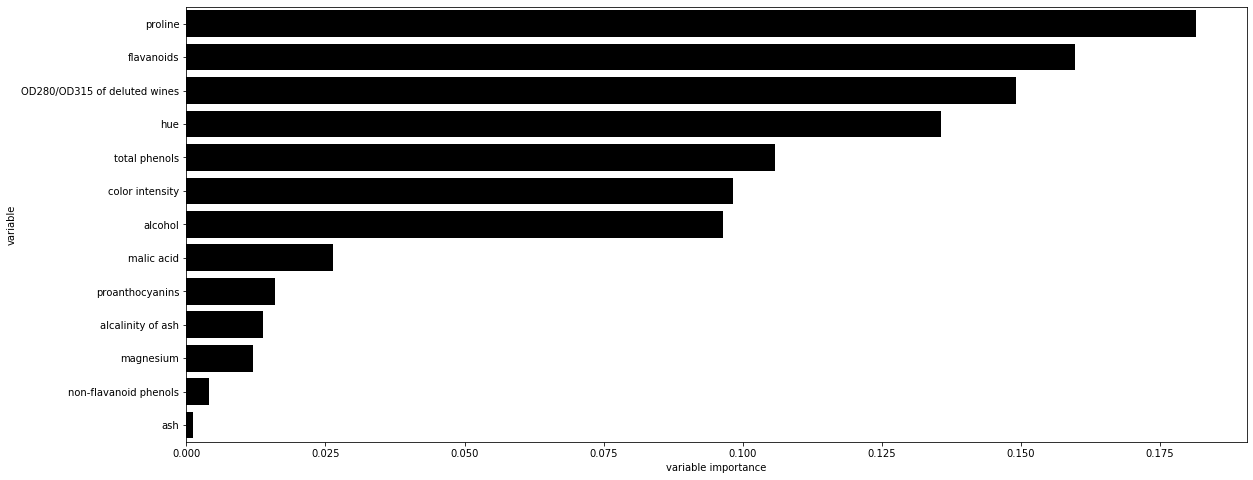

In [5]:
#--- Discover the expert (empirical) knowledge (Random Forest: top-K important features based on entropy) ---#

random_forest_model = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 5, max_depth = 4, random_state = 17, criterion = "entropy") #The maximum depth of the tree a.k.a., conditions
random_forest_model.fit(X, Y) 
importances = random_forest_model.feature_importances_

forest = RandomForestClassifier(random_state=0)
forest.fit(X, Y)

frame = {'variable': X.columns, 'variable importance': importances}
forest_importances_df = pd.DataFrame(frame)

#--- Create the dictionary with sorted (high to low) features based on importance ---#

feature_importance_dict = dict(zip(X.columns, importances))
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse = True))

#--- Get K items in dictionary ---#

top_K_features = dict(list(sorted_feature_importance_dict.items())[0: K])
bottom_K_features = dict(list(sorted_feature_importance_dict.items())[-K:])
random_K_features = dict(random.sample(list(sorted_feature_importance_dict.items()), K))
plt.figure(figsize = (19,8))
sns.barplot(x ='variable importance', y ='variable', data = forest_importances_df, color = 'black', order = forest_importances_df.sort_values('variable importance',ascending = False).variable)

#plt.savefig('variable_importance_[%s].png' % df.name, dpi=300) 

In [6]:
#--- Write to file expert_knowledge.csv first the *, selectors ---#

with open('expert_knowledge_top_K.csv', mode='wt', encoding='utf-8') as expert_file:
    expert_file.write('\n*\n')
    expert_file.write('\n'.join(list(top_K_features.keys())))

with open('expert_knowledge_bottom_K.csv', mode='wt', encoding='utf-8') as expert_file:
    expert_file.write('\n*\n')
    expert_file.write('\n'.join(list(bottom_K_features.keys())))
    
with open('expert_knowledge_random_K.csv', mode='wt', encoding='utf-8') as expert_file:
    expert_file.write('\n*\n')
    expert_file.write('\n'.join(list(random_K_features.keys())))


In [7]:
print(name.replace(" ", "-"))
print('\n')

roc = {label: [] for label in Y.unique()}
#_X_ = np.array(X)
#_Y_ = np.array(Y)


model_S_CLASSY = RuleListClassifier(discretization = 'static')
model_CLASSY = RuleListClassifier(discretization = 'static')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

print('\nS-CLASSY BOTTOM')
model_S_CLASSY.fit_S_CLASSY(X_train, y_train, Y.unique(), 'expert_knowledge_bottom_K.csv')
y_pred = model_S_CLASSY.predict(X_test)                                                                 
y_pred_train = model_S_CLASSY.predict(X_train)       
print('Accuracy:', accuracy_score(y_test.values, y_pred))

print('\nS-CLASSY RANDOM')
model_S_CLASSY.fit_S_CLASSY(X_train, y_train, Y.unique(), 'expert_knowledge_random_K.csv')
y_pred = model_S_CLASSY.predict(X_test)                                                                 
y_pred_train = model_S_CLASSY.predict(X_train)       
print('Accuracy:', accuracy_score(y_test.values, y_pred))

print('\nS-CLASSY TOP')
model_S_CLASSY.fit_S_CLASSY(X_train, y_train, Y.unique(), 'expert_knowledge_top_K.csv')
y_pred = model_S_CLASSY.predict(X_test)                                                                 
y_pred_train = model_S_CLASSY.predict(X_train)       
print('Accuracy:', accuracy_score(y_test.values, y_pred))

print('\nCLASSY')
model_CLASSY = RuleListClassifier(discretization = "static")
model_CLASSY.fit(X_train, y_train, Y.unique())
y_pred = model_CLASSY.predict(X_test)
y_pred_train = model_CLASSY.predict(X_train) 
print('Accuracy:', accuracy_score(y_test.values, y_pred))



Wine-dataset



S-CLASSY BOTTOM
Preferred variables:	 ['magnesium', 'non-flavanoid phenols', 'ash']
Rule list: IF non-flavanoid phenols >= 36.0 AND OD280/OD315 of deluted wines < 57.0 AND hue < 52.0 THEN usage = 33; 	ELSE IF proline < 65.0 THEN usage = 44; 	ELSE IF 1.0 <= alcohol < 5.0 THEN usage = 17; 	ELSE usage = 30; 
S-CLASSY (bottom) runtime - sec:  1.3081426620483398


Accuracy: 0.9074074074074074

S-CLASSY RANDOM
Preferred variables:	 ['proline', 'total phenols', 'malic acid']
Rule list: IF proline >= 61.0 AND hue < 52.0 AND OD280/OD315 of deluted wines < 57.0 THEN usage = 33; 	ELSE IF proline < 65.0 THEN usage = 44; 	ELSE IF 1.0 <= alcohol < 5.0 THEN usage = 17; 	ELSE usage = 30; 
S-CLASSY (random) runtime - sec:  1.306015968322754


Accuracy: 0.9074074074074074

S-CLASSY TOP
Preferred variables:	 ['proline', 'flavanoids', 'OD280/OD315 of deluted wines']
Rule list: IF flavanoids >= 31.0 AND OD280/OD315 of deluted wines < 57.0 AND hue < 52.0 THEN usage = 33; 	ELSE IF proline < 6